In [23]:
import networkx as nx
import numpy as np

#그래프를 생성하는 부분 n:노트개수 m:새롭게 추가되는 node와 기존 node들 사이에 생성되는 edge의 개수
def gen_webgraph(n, m):
    G = nx.DiGraph(nx.barabasi_albert_graph(n,m))
    rands = np.random.choice(n, n//2, replace=False)
    G.remove_edges_from(np.array(G.edges)[rands])
    return G

#그래프를 받아 구글 매트릭스 받는부분
def get_google_matrix(G, d=0.15):
    n = G.number_of_nodes()
    A = nx.to_numpy_array(G).T
    # for sink nodes
    is_sink = np.sum(A, axis=0)==0
    B = (np.ones_like(A) - np.identity(n)) / (n-1)
    A[:, is_sink] += B[:, is_sink]
    
    D_inv = np.diag(1/np.sum(A, axis=0))
    M = np.dot(A, D_inv) 
    
    # for disconnected components
    M = (1-d)*M + d*np.ones((n,n))/n
    return M

def l1(x):
    return np.sum(np.abs(x))

#고유벡터로 페이지랭크 구하는 함수
def pagerank_edc(G, d=0.15):
    M = get_google_matrix(G, d=d)
    eigenvalues, eigenvectors = np.linalg.eig(M)
    idx = eigenvalues.argsort()[-1]
    largest = np.array(eigenvectors[:,idx]).flatten().real
    return largest / l1(largest)

#power iteration method로 페이지랭크 구하는 함수
def pagerank_power(G, d=0.15, max_iter=100, eps=1e-9):
    M = get_google_matrix(G, d=d)
    n = G.number_of_nodes()
    V = np.ones(n)/n
    for _ in range(max_iter):
        V_last = V
        V = np.dot(M, V)
        if  l1(V-V_last)/n < eps:
            return V
    return V

input_size=[5,200,400,800,1600,3200]

# 고유벡터로 구하는법

주어진 그래프로 확률론적 인접행렬을 구할수 있다. 

구한 확률론적 인접행렬이 M일때, 구글행렬 G는 

G=dM+(1-d)E (d는 보통 0.85)

구글행렬의 고유벡터중 가장 큰값을 가지는 고유값를 이용(가장 큰 고유값는 1을 넘지 않음) 

가장큰 고유값에 대응하는 고유벡터인 dominant eigenvector가 pagerank가 됨

In [24]:
import time
time_edc=[]
for i in range(6):
    start=time.time()
    pagerank_edc(gen_webgraph(input_size[i],3))
    end=time.time()
    time_edc.append(end-start)
    
time_edc

[0.0023310184478759766,
 0.06243491172790527,
 0.1222081184387207,
 0.8775279521942139,
 4.620495319366455,
 23.323164224624634]

# Power Iteration Method

벡터 v를 1/N으로 모두 같게 초기화 시킨다 (N은 노드의 수, v=[1/N , 1/N, 1/N , ... 1/N])

결정한 iteration수만큼 다음 식을 반복시킨다

r_k+1=G*v_k (G는 구글행렬, v_k는 k번째의 v값)

iteration만큼 반복한후 구한 r_k+1이 pagerank가 됨

In [25]:
time_power=[]
for i in range(6):
    start=time.time()
    pagerank_power(gen_webgraph(input_size[i],3))
    end=time.time()
    time_power.append(end-start)
    
time_power

[0.0010769367218017578,
 0.008579730987548828,
 0.056365013122558594,
 0.045393943786621094,
 0.1542649269104004,
 0.7586979866027832]

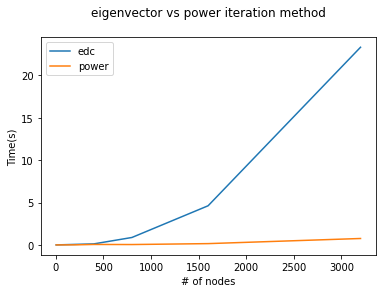

In [39]:
import matplotlib.pyplot as plt
plt.plot(input_size,time_edc,input_size,time_power)

plt.xlabel('# of nodes')
plt.ylabel('Time(s)')
plt.title('eigenvector vs power iteration method\n')

plt.legend(['edc','power'])
plt.show()